Using device: cuda
Number of items (animals): 100
Number of relations: 5
Number of attributes: 116
Input patterns shape: torch.Size([500, 105])
Output patterns shape: torch.Size([500, 116])

--- Phase 1 Training ---
Epoch 50 Loss: 0.0223
Epoch 100 Loss: 0.0208
Epoch 150 Loss: 0.0201
Epoch 200 Loss: 0.0197
Epoch 250 Loss: 0.0195
Epoch 300 Loss: 0.0192
Epoch 350 Loss: 0.0189
Epoch 400 Loss: 0.0185
Epoch 450 Loss: 0.0182
Epoch 500 Loss: 0.0179

--- Phase 2 Training ---
Epoch 550 Loss: 0.0175
Epoch 600 Loss: 0.0173
Epoch 650 Loss: 0.0171
Epoch 700 Loss: 0.0169
Epoch 750 Loss: 0.0167
Epoch 800 Loss: 0.0166
Epoch 850 Loss: 0.0165
Epoch 900 Loss: 0.0163
Epoch 950 Loss: 0.0162
Epoch 1000 Loss: 0.0161

--- Phase 3 Training ---
Epoch 1050 Loss: 0.0160
Epoch 1100 Loss: 0.0159
Epoch 1150 Loss: 0.0158
Epoch 1200 Loss: 0.0157
Epoch 1250 Loss: 0.0155
Epoch 1300 Loss: 0.0154
Epoch 1350 Loss: 0.0152
Epoch 1400 Loss: 0.0150
Epoch 1450 Loss: 0.0149
Epoch 1500 Loss: 0.0147
Epoch 1550 Loss: 0.0147
Epoch 16

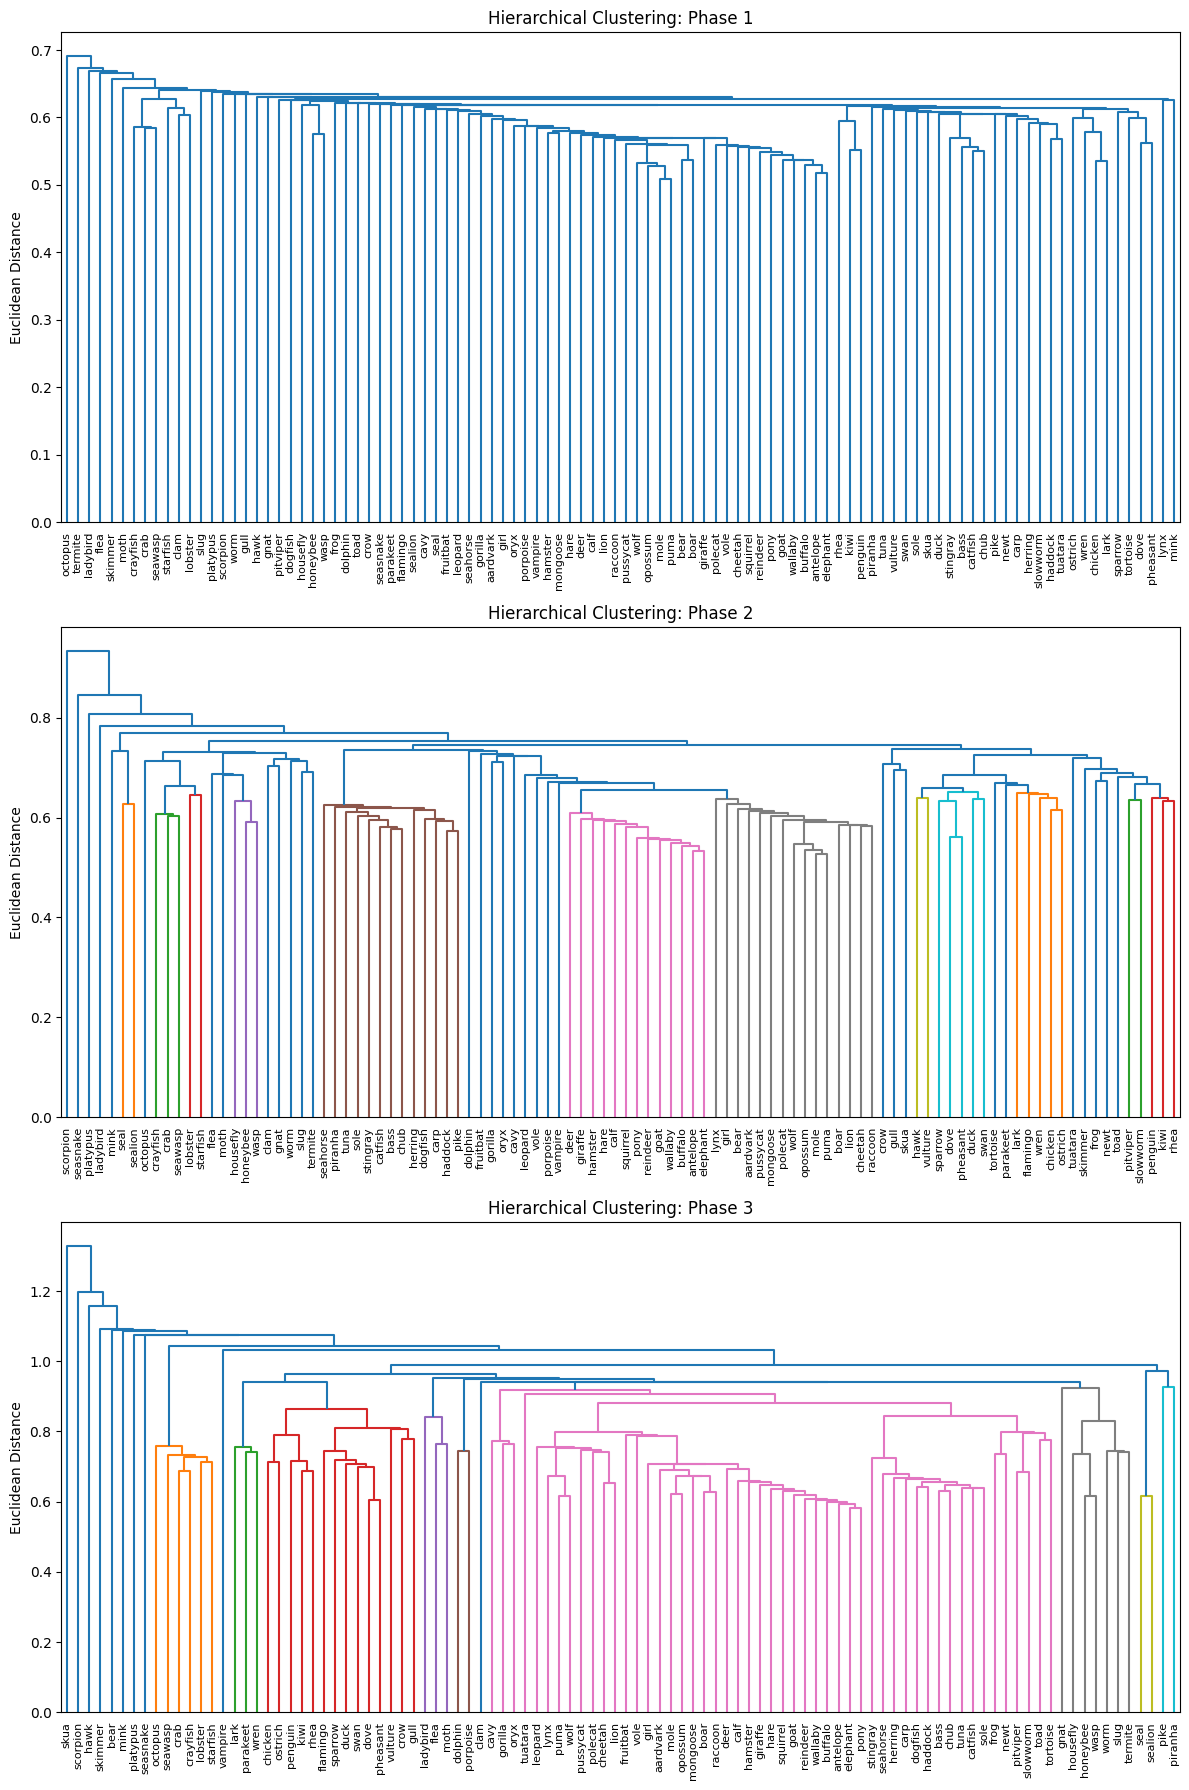


Final Performance on Clean Data:
Final Loss: 0.0140
Final Accuracy: 0.9971

Degradation Analysis Results:
Noise Level 0.1: Loss=0.0168, Accuracy=0.9934
Noise Level 0.2: Loss=0.0227, Accuracy=0.9866
Noise Level 0.3: Loss=0.0288, Accuracy=0.9816
Saved Degradation Analysis Plot as 'degradation_analysis.png' in 'plots'


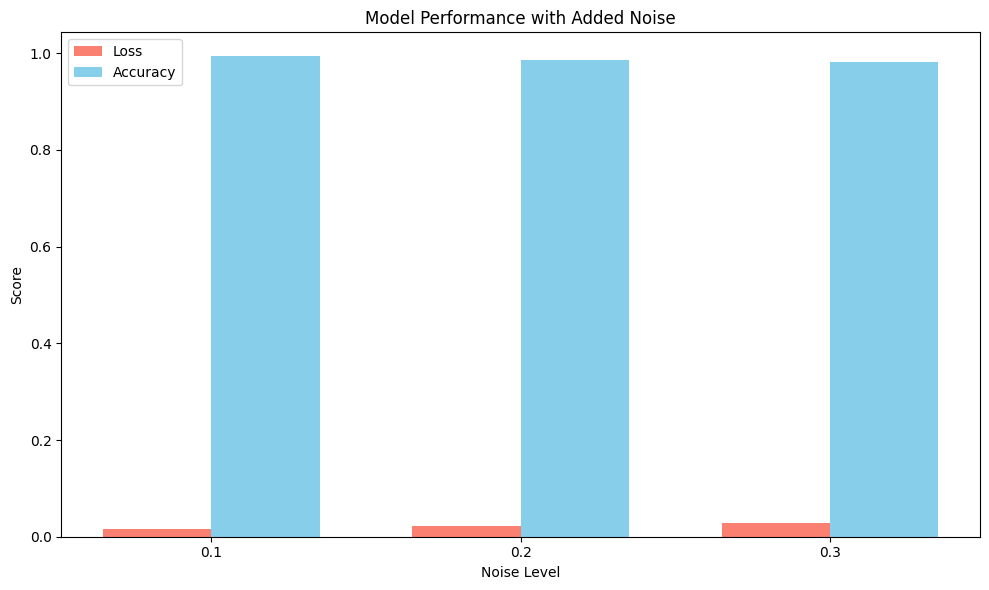

Saved Dendrograms Plot as 'dendrograms_noise_0.1.png' in 'plots'


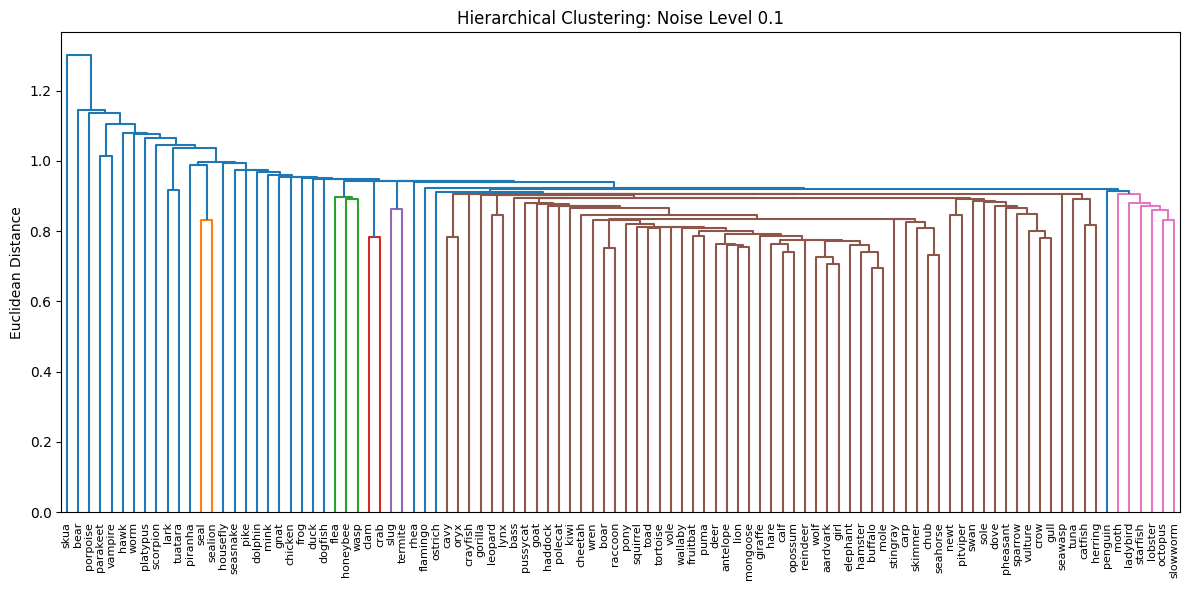

Saved Dendrograms Plot as 'dendrograms_noise_0.2.png' in 'plots'


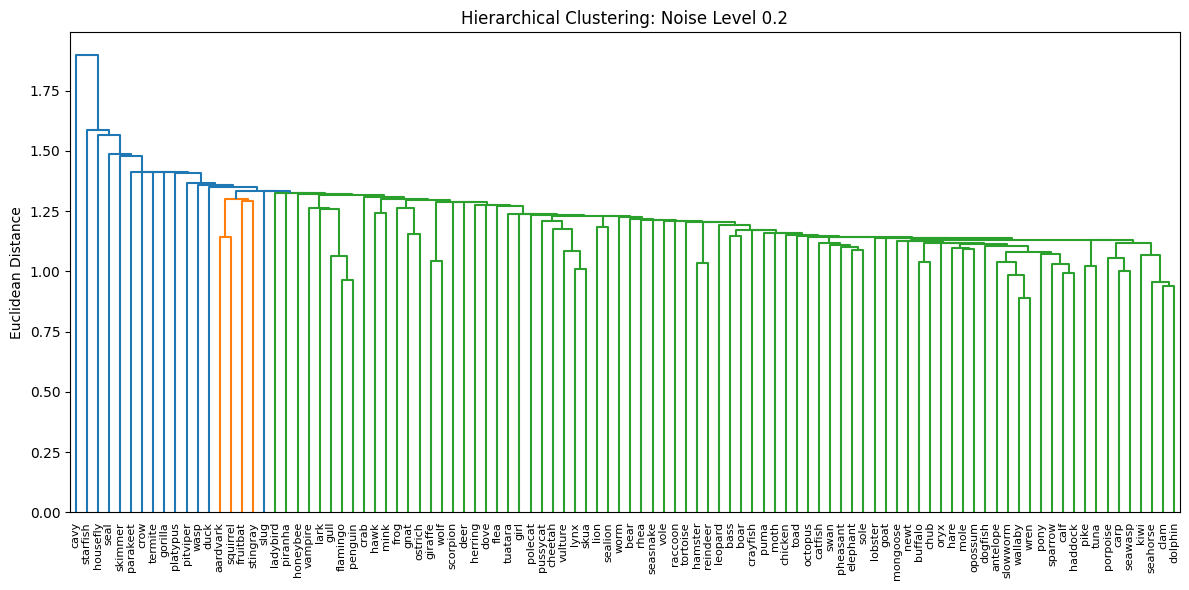

Saved Dendrograms Plot as 'dendrograms_noise_0.3.png' in 'plots'


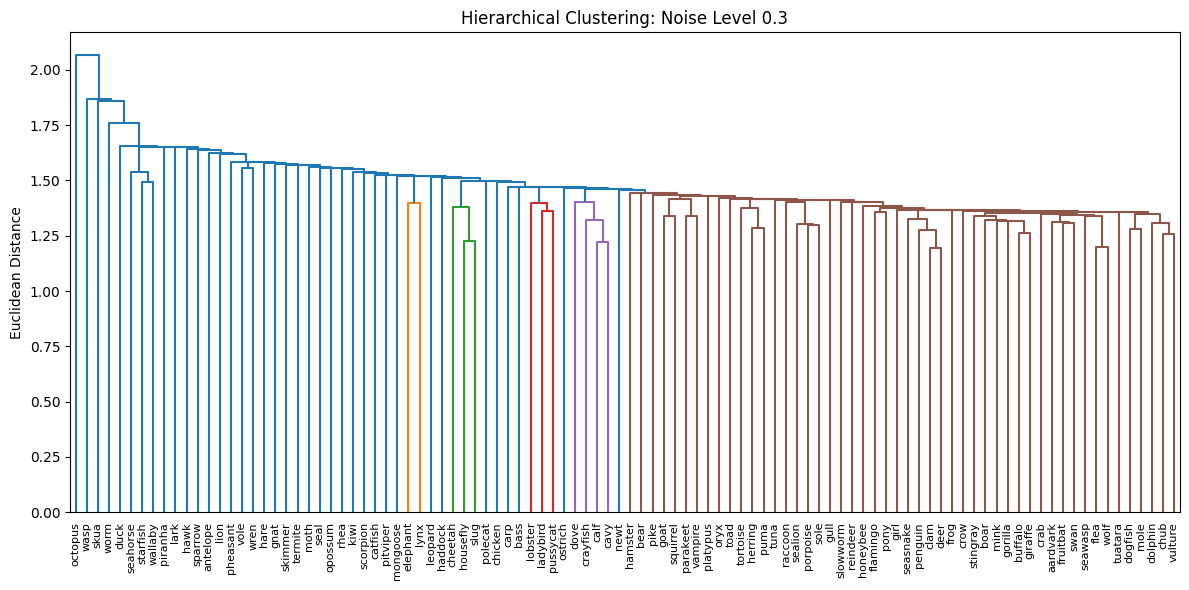

Model saved to 'plots\semantic_cognition_model.pth'


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.functional import relu
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

###############################
# 1. Device Configuration
###############################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

###############################
# 2. Data Loading
###############################
path_can = "animals_can.xlsx"
path_has = "animals_has.xlsx"
path_produce = "animals_produce.xlsx"
path_is = "animals_is.xlsx"
path_eats = "animals_eats.xlsx"

df_can = pd.read_excel(path_can)
df_has = pd.read_excel(path_has)
df_produce = pd.read_excel(path_produce)
df_is = pd.read_excel(path_is)
df_eats = pd.read_excel(path_eats)

# Extract animal list
animals = df_can['animal_name'].values
nobj = len(animals)
animal2idx = {a: i for i, a in enumerate(animals)}

names_relations = np.array(["can", "has", "produce", "is", "eats"])
nrel = len(names_relations)

# Extract attribute names from each file
can_attributes = df_can.columns[1:].tolist()
has_attributes = df_has.columns[1:].tolist()
produce_attributes = df_produce.columns[1:].tolist()
is_attributes = df_is.columns[1:].tolist()
eats_attributes = ["prey_" + str(i) for i in range(nobj)]

names_attributes = np.array(can_attributes + has_attributes + produce_attributes + is_attributes + eats_attributes)
nattributes = len(names_attributes)
print("Number of items (animals):", nobj)
print("Number of relations:", nrel)
print("Number of attributes:", nattributes)

# Convert each file to numpy
can_data = df_can[can_attributes].to_numpy()       # shape: [nobj, len(can_attributes)]
has_data = df_has[has_attributes].to_numpy()       # shape: [nobj, ...]
produce_data = df_produce[produce_attributes].to_numpy()
is_data = df_is[is_attributes].to_numpy()

# Process eats data into a binary matrix
eats_binary = np.zeros((nobj, nobj))
for i, row in df_eats.iterrows():
    prey_str = str(row['prey']).strip()
    if prey_str.lower() != 'nan' and prey_str != '':
        prey_list = [p.strip() for p in prey_str.split(",")]
        # Assuming 1-based indices for prey animals:
        try:
            prey_indices = [int(x)-1 for x in prey_list]
            for pi in prey_indices:
                if 0 <= pi < nobj:
                    eats_binary[i, pi] = 1
        except:
            pass

###############################
# 3. Construct Input-Output Patterns
###############################
# Relation attribute index offsets:
# CAN: 3 attrs
# HAS: 7 attrs
# PRODUCE: 3 attrs
# IS: 3 attrs
# EATS: nobj attrs
# Layout: CAN(0:3), HAS(3:10), PRODUCE(10:13), IS(13:16), EATS(16:16+nobj)

def build_target_vector(relation_idx, animal_idx):
    vec = np.zeros(nattributes)
    if relation_idx == 0:
        vec[0:3] = can_data[animal_idx, :]
    elif relation_idx == 1:
        vec[3:10] = has_data[animal_idx, :]
    elif relation_idx == 2:
        vec[10:13] = produce_data[animal_idx, :]
    elif relation_idx == 3:
        vec[13:16] = is_data[animal_idx, :]
    elif relation_idx == 4:
        vec[16:16+nobj] = eats_binary[animal_idx, :]
    return vec

input_pats_list = []
output_pats_list = []

for i_animal in range(nobj):
    for i_rel in range(nrel):
        animal_one_hot = np.zeros(nobj)
        animal_one_hot[i_animal] = 1
        rel_one_hot = np.zeros(nrel)
        rel_one_hot[i_rel] = 1
        inp = np.concatenate((animal_one_hot, rel_one_hot))
        out = build_target_vector(i_rel, i_animal)
        input_pats_list.append(inp)
        output_pats_list.append(out)

input_pats = torch.tensor(np.array(input_pats_list), dtype=torch.float, device=device)
output_pats = torch.tensor(np.array(output_pats_list), dtype=torch.float, device=device)
N = input_pats.shape[0]

print("Input patterns shape:", input_pats.shape)
print("Output patterns shape:", output_pats.shape)

###############################
# 4. Neural Network Definition
###############################
class Net(nn.Module):
    def __init__(self, hidden_size=15):
        super(Net, self).__init__()
        self.item2rep = nn.Linear(nobj, nobj)
        self.rep2hid = nn.Linear(nobj+nrel, hidden_size)
        self.hid2att = nn.Linear(hidden_size, nattributes)

    def forward(self, x):
        x = x.view(-1, nobj+nrel)
        x_pat_item = x[:, :nobj]
        x_pat_rel = x[:, nobj:]
        rep = relu(self.item2rep(x_pat_item))
        combined = torch.cat((rep, x_pat_rel), dim=1)
        hidden = relu(self.rep2hid(combined))
        output = torch.sigmoid(self.hid2att(hidden))
        return output, hidden, rep

mynet = Net(hidden_size=15).to(device)

###############################
# 5. Training Function
###############################
def train_model(mynet, epoch_count, nepochs_additional=5000, learning_rate=0.1, print_every=50):
    mynet.train()
    optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for e in range(nepochs_additional):
        error_epoch = 0.0
        perm = np.random.permutation(N)
        for p in perm:
            mynet.zero_grad()
            input_pattern = input_pats[p, :].unsqueeze(0)
            target = output_pats[p, :].unsqueeze(0)
            output, hidden, rep = mynet(input_pattern)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            error_epoch += loss.item()
        error_epoch /= float(N)
        if (e+1) % print_every == 0:
            print(f"Epoch {epoch_count+e+1} Loss: {error_epoch:.4f}")
    return epoch_count + nepochs_additional

def get_rep(net, device=device):
    # Extract representation for each item (animal only)
    input_clean = torch.zeros(nobj, nobj+nrel, device=device)
    for i in range(nobj):
        input_clean[i, i] = 1.0
    with torch.no_grad():
        output, hidden, rep = net(input_clean)
    return rep.detach().cpu().numpy()

###############################
# 6. Dendrogram and Plotting
###############################
def plot_dendo(rep_dict, names, save_path=None, filename_suffix=""):
    num_plots = len(rep_dict)
    plt.figure(figsize=(12, 6 * num_plots))
    for idx, (desc, rep) in enumerate(rep_dict.items(), 1):
        linked = linkage(rep, "single")
        plt.subplot(num_plots, 1, idx)
        dendrogram(linked, labels=names, orientation='top', leaf_rotation=90., leaf_font_size=8.)
        plt.title(f"Hierarchical Clustering: {desc}")
        plt.ylabel("Euclidean Distance")
    plt.tight_layout()
    if save_path:
        filename = "dendrograms" + ("_" + filename_suffix if filename_suffix else "") + ".png"
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, filename), dpi=300, bbox_inches='tight')
        print(f"Saved Dendrograms Plot as '{filename}' in '{save_path}'")
    plt.show()

###############################
# 7. Degradation (Add Noise) Analysis
###############################
def add_noise(input_data, noise_level=0.1):
    noise = torch.randn_like(input_data) * noise_level
    noisy_input = input_data + noise
    noisy_input = torch.clamp(noisy_input, 0, 1)  # Ensure values are within [0,1]
    return noisy_input

def compute_final_metrics(net, input_data, target_data, threshold=0.5):
    net.eval()
    criterion = nn.MSELoss()
    with torch.no_grad():
        output, _, _ = net(input_data)
        loss = criterion(output, target_data).item()
        predictions = (output.cpu().numpy() > threshold).astype(int)
        targets = target_data.cpu().numpy().astype(int)
        correct_labels = (predictions == targets).sum()
        total_labels = targets.size
        accuracy = correct_labels / total_labels
    return loss, accuracy

def degradation_analysis(net, input_pats, output_pats, noise_levels=[0.1, 0.2, 0.3]):
    results = {}
    representations = {}
    for noise_level in noise_levels:
        noisy_input = add_noise(input_pats, noise_level=noise_level)
        loss, accuracy = compute_final_metrics(net, noisy_input, output_pats, threshold=0.5)
        results[noise_level] = {
            'loss': loss,
            'accuracy': accuracy
        }
        with torch.no_grad():
            _, _, rep = net(noisy_input[:nobj])  
            # taking first nobj patterns corresponding to just items (assumes first nobj patterns represent items with a particular relation)
            # Actually, we should isolate items-only input if we want a fair representation extraction. 
            # We'll do the same approach as get_rep but now with noise.
            # Redefine representation extraction under noise:
            rep_noisy = get_rep_under_noise(net, noise_level)
        representations[noise_level] = rep_noisy
    return results, representations

def get_rep_under_noise(net, noise_level, device=device):
    # Extract representation for items alone, but add noise to the input:
    input_clean = torch.zeros(nobj, nobj+nrel, device=device)
    for i in range(nobj):
        input_clean[i, i] = 1.0
    input_noisy = add_noise(input_clean, noise_level=noise_level)
    with torch.no_grad():
        _, _, rep = net(input_noisy)
    return rep.detach().cpu().numpy()

def plot_degradation(degradation_results, save_path=None):
    noise_levels = list(degradation_results.keys())
    losses = [degradation_results[n]['loss'] for n in noise_levels]
    accuracies = [degradation_results[n]['accuracy'] for n in noise_levels]

    x = np.arange(len(noise_levels))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, losses, width, label='Loss', color='salmon')
    plt.bar(x + width/2, accuracies, width, label='Accuracy', color='skyblue')

    plt.xlabel('Noise Level')
    plt.ylabel('Score')
    plt.title('Model Performance with Added Noise')
    plt.xticks(x, noise_levels)
    plt.legend()
    plt.tight_layout()
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, "degradation_analysis.png"), dpi=300, bbox_inches='tight')
        print(f"Saved Degradation Analysis Plot as 'degradation_analysis.png' in '{save_path}'")
    plt.show()

###############################
# 8. Training and Analysis Flow
###############################
if __name__ == "__main__":
    save_directory = "plots"
    os.makedirs(save_directory, exist_ok=True)

    learning_rate = 0.1
    nepochs_phase1 = 500
    nepochs_phase2 = 1000
    nepochs_phase3 = 2500
    epoch_count = 0

    print("\n--- Phase 1 Training ---")
    epoch_count = train_model(mynet, epoch_count, nepochs_additional=nepochs_phase1, learning_rate=learning_rate)
    rep1 = get_rep(mynet)

    print("\n--- Phase 2 Training ---")
    epoch_count = train_model(mynet, epoch_count, nepochs_additional=(nepochs_phase2 - nepochs_phase1), learning_rate=learning_rate)
    rep2 = get_rep(mynet)

    print("\n--- Phase 3 Training ---")
    epoch_count = train_model(mynet, epoch_count, nepochs_additional=(nepochs_phase3 - nepochs_phase2), learning_rate=learning_rate)
    rep3 = get_rep(mynet)

    # Plot clean dendrograms
    rep_clean_dict = {
        "Phase 1": rep1,
        "Phase 2": rep2,
        "Phase 3": rep3
    }
    plot_dendo(rep_clean_dict, animals, save_path=save_directory, filename_suffix="clean")

    # Evaluate on clean data
    final_loss, final_accuracy = compute_final_metrics(mynet, input_pats, output_pats, threshold=0.5)
    print("\nFinal Performance on Clean Data:")
    print(f"Final Loss: {final_loss:.4f}")
    print(f"Final Accuracy: {final_accuracy:.4f}")

    # Degradation Analysis
    noise_levels = [0.1, 0.2, 0.3]
    degradation_results, noisy_reps = degradation_analysis(mynet, input_pats, output_pats, noise_levels=noise_levels)

    print("\nDegradation Analysis Results:")
    for noise, metrics in degradation_results.items():
        print(f"Noise Level {noise}: Loss={metrics['loss']:.4f}, Accuracy={metrics['accuracy']:.4f}")

    plot_degradation(degradation_results, save_path=save_directory)

    # Plot dendrograms under noise
    for noise_level, rep in noisy_reps.items():
        desc = f"Noise Level {noise_level}"
        rep_noisy_dict = {desc: rep}
        suffix = f"noise_{noise_level}"
        plot_dendo(rep_noisy_dict, animals, save_path=save_directory, filename_suffix=suffix)

    # Save the model
    model_path = os.path.join(save_directory, "semantic_cognition_model.pth")
    torch.save(mynet.state_dict(), model_path)
    print(f"Model saved to '{model_path}'")

###############################
# Does this code meet expectations?
###############################
# This code:
# - Loads your given data
# - Prepares it in a way similar to the conceptual framework of semantic cognition modeling
# - Uses CUDA if available
# - Trains a network and prints training progress
# - Provides final evaluation on clean data
# - Performs degradation analysis with noise at multiple levels
# - Saves dendrograms and degradation plots at high resolution (dpi=300)
#
# It should meet the conceptual idea behind extending the Rogers & McClelland (2003) model
# to a new, larger dataset, and analyzing the dynamics of differentiation and degradation.
